## 1. Batch vs. Mini-Batch

**数据初始化：**  
1.二标Moon数据集  
2.采用随机种子设为定值，方便复现  
3.绘制图像  
4.在深度学习中，`train_size`, `dev_size`, `test_size` 可以这样分*8/1/1*, 或者当数据集极大时，例如：`10 millions`, `train vs. test : 9 /1`

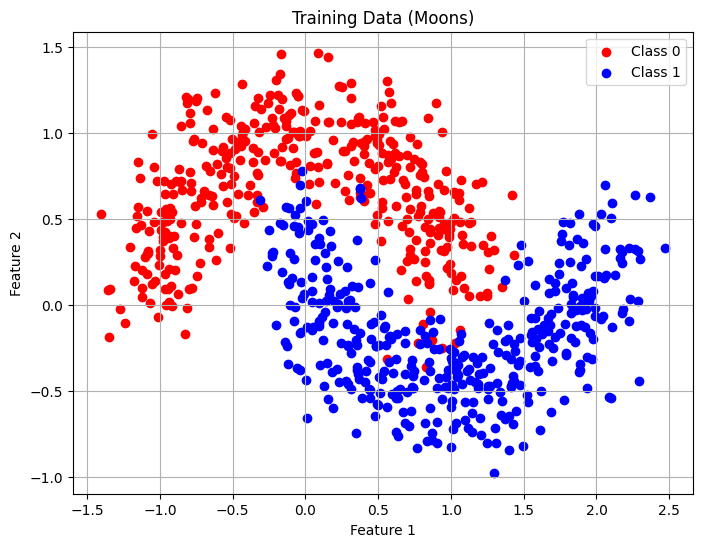

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import torch
from torch.utils.data import DataLoader, TensorDataset
import random
# 设置随机种子
seed = 43
np.random.seed(seed)  # 设置 NumPy 随机种子
random.seed(seed)     # 设置 Python 内置随机模块的种子
torch.manual_seed(seed)  # 设置 CPU 随机种子

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  


# 生成难以分类的二分类数据
X, y = make_moons(n_samples=1000, noise=0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# 转换为 PyTorch 张量
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

plt.figure(figsize=(8, 6))
plt.scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], color='red', label='Class 0')
plt.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], color='blue', label='Class 1')
plt.title('Training Data (Moons)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()


**设置简单结构：**  
1.input->linear->relu->linear->output

In [22]:
import torch.nn as nn
import torch.optim as optim

# 定义神经网络模型
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(2, 128)  # 输入层到隐藏层
        self.fc2 = nn.Linear(128, 2)   # 隐藏层到输出层

    def forward(self, x):
        x = torch.relu(self.fc1(x))   # 激活函数
        x = self.fc2(x)
        return x

**训练模型：**  
1.这里主要为了区分`batch`与`mini-batch`的区别，将`mini-batch`设置为32，`batch`则设置为`ALL=n_samples`  
2.`epoch`设置为100轮次  
3.`fun_train`为设置训练函数，目的是为了观察`batch`不同的影响  
4.准确率函数也方便对比

In [23]:
device = 'cuda'
model = SimpleNN().to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.01)
def fun_train(batch):
    dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
    num_epochs = 10
    for epoch in range(num_epochs):
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()  # 清除上一步的梯度
            outputs = model(batch_x)  # 前向传播
            loss = criterion(outputs, batch_y)  # 计算损失
            loss.backward()  # 反向传播
            optimizer.step()  # 更新参数
    print(f'Epoch = 10, batch = {batch}, Loss: {loss.item():.4f}')

In [24]:
def calculate_accuracy(model, batch):
    dataloader = dataloader = DataLoader(test_dataset, batch_size=batch, shuffle=False)
    model.eval()  # 设置模型为评估模式
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            _, predicted = torch.max(outputs.data, 1)  # 获取预测的类别
            total += batch_y.size(0)  # 累计样本数
            correct += (predicted == batch_y).sum().item()  # 统计正确预测数
    accuracy = correct / total  # 计算准确率
    return accuracy

Epoch = 10, batch = 32, Loss: 0.1232
Train Accuracy(batch = 32): 97.00%
Epoch = 10, batch = 1000, Loss: 0.0701
Train Accuracy(batch = 1000): 96.50%


In [ ]:
fun_train(32)
train_accuracy = calculate_accuracy(model, 32)
print(f'Train Accuracy(batch = 32): {train_accuracy * 100:.2f}%')

fun_train(1000)
train_accuracy_1 = calculate_accuracy(model, 1000)
print(f'Train Accuracy(batch = 1000): {train_accuracy_1 * 100:.2f}%')

显然，`Mini-Batch is win!`这可能在直观上因为训练数据集的大小有关，所以才显现的提升略微。

In [26]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    with torch.no_grad():
        Z = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]).to(device))
        Z = torch.argmax(Z, dim=1).cpu().numpy()
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='red', label='Class 0')
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Class 1')
    plt.title('Decision Boundary')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch = 10, batch = 32, Loss: 0.0919
Train Accuracy(batch = 32): 97.50%


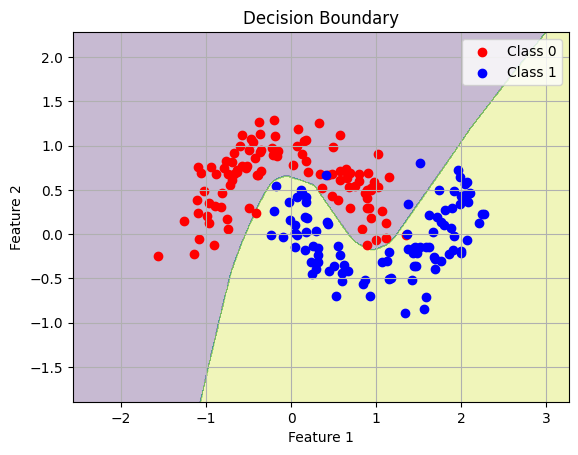

Epoch = 10, batch = 1000, Loss: 0.0701
Train Accuracy(batch = 1000): 97.00%


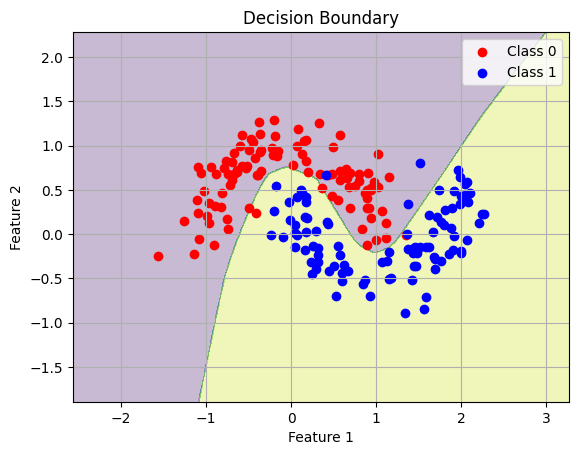

In [27]:
fun_train(32)
train_accuracy = calculate_accuracy(model, 32)
print(f'Train Accuracy(batch = 32): {train_accuracy * 100:.2f}%')
plot_decision_boundary(model, X_test, y_test)

fun_train(1000)
train_accuracy_1 = calculate_accuracy(model, 1000)
print(f'Train Accuracy(batch = 1000): {train_accuracy_1 * 100:.2f}%')
plot_decision_boundary(model, X_test, y_test)

## 2. EMA指数加权滑动平均 

$$EMA_t=α×T_t+(1−α)×EMAT_{t−1} \tag{1}$$

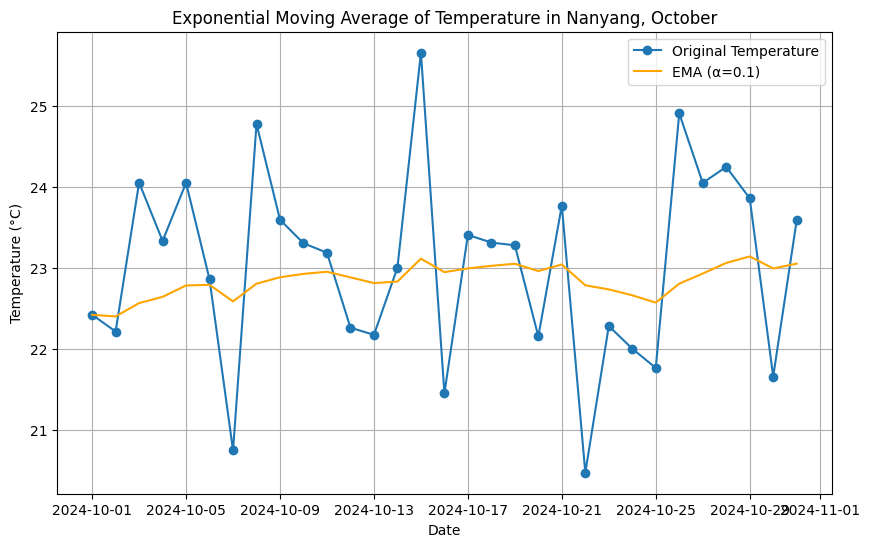

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sample temperature data for 31 days
dates = pd.date_range(start='2024-10-01', periods=31)
# Assuming max_temperatures from earlier data as an example
max_temperatures = [23 + np.random.randn() for _ in range(31)]

# Convert to a DataFrame
temperature_data = pd.DataFrame({
    'Date': dates,
    'Max Temperature': max_temperatures
})

# Calculate Exponential Moving Average
def exponential_moving_average(data, alpha=0.5):
    ema = [data[0]]  # Initialize EMA with the first temperature
    for temp in data[1:]:
        ema.append(alpha * temp + (1 - alpha) * ema[-1])
    return ema

# Apply EMA
alpha = 0.1  # Smoothing factor
temperature_data['EMA'] = exponential_moving_average(temperature_data['Max Temperature'], alpha)

# Plot the original and EMA temperatures
plt.figure(figsize=(10, 6))
plt.plot(temperature_data['Date'], temperature_data['Max Temperature'], label='Original Temperature', marker='o')
plt.plot(temperature_data['Date'], temperature_data['EMA'], label='EMA (α=0.1)', color='orange')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Exponential Moving Average of Temperature in Nanyang, October')
plt.legend()
plt.grid(True)
plt.show()


**偏差校正在初始值中的作用及其对成本的影响** **ANSWER form AI.**

在训练机器学习模型（如基于动量的优化器，例如 Adam）时，通常需要使用**偏差校正**来纠正初始值问题，尤其是在训练初期。以下是详细解释：

### 偏差校正的必要性
当计算移动平均（如梯度的 EMA 或平方梯度时），初始值往往会偏向于零。这种偏差发生的原因是初期历史数据不足，无法形成准确的平均值。

例如，在计算系列的 EMA 时，平均值主要依赖于初始值，这些初始值可能无法准确反映底层趋势。尤其当平滑因子 $ \alpha  $较小时，EMA 对历史数据的依赖性增强，偏差问题更为明显。

### 对成本的影响
1. **未校正偏差**：如果优化器（如 Adam）中使用的 EMA 没有进行偏差校正，可能会导致训练早期收敛速度缓慢。这种延迟可能是因为优化步骤过小或不稳定，影响了成本函数的下降过程。
2. **偏差校正机制**：在像 Adam 这样的算法中，偏差校正通过一个因子来调整 EMA，以补偿初始偏差：

$$   
   \text{Corrected EMA}_t = \frac{\text{EMA}_t}{1 - \beta^t}
$$  
   其中 $ \beta $ 是指数衰减率，$ t $ 是时间步。这种缩放确保 EMA 更接近真实值，使更新更稳定有效，从而在早期周期中更有效地降低成本函数。

### 示例影响
- **没有偏差校正**：优化器可能会采取不必要的小步长，导致收敛缓慢，甚至陷入次优解中。
- **有偏差校正**：优化器能够采取更合适的步长，从而加速收敛，能够更有效地最小化成本函数。

总结来说，**偏差校正**在初始值中起着关键作用，确保优化算法能够从一开始就高效运行，进而改善成本函数的行为，加快整体训练的收敛速度。

3.RMS prop(Hinton)  
4.Adma  
5.learn-rate decay

在深度学习中，优化算法是影响模型训练效果的重要因素。以下是 梯度下降法（GD）、动量法（Momentum） 和 自适应动量估计（Adam） 三种优化方法的比较。
1. 梯度下降法（GD） 
优点：  
简单易实现，适用于多种情况。   
在全局凸优化问题中能够找到全局最优解。  
缺点： 
对学习率敏感，学习率过大会导致训练不稳定，过小则收敛缓慢。  
在鞍点和局部极小值附近可能收敛很慢。  
2. 动量法（Momentum）  
优点：  
在更新权重时，考虑之前的梯度信息，能够加快收敛速度。  
有助于减少振荡，使得模型在深谷和鞍点之间更加平滑地移动。  
缺点：  
引入了一个额外的超参数（动量因子），需要调优。  
仍然可能会在某些情况下收敛到局部最优。   
3. 自适应动量估计（Adam）  
优点：  
结合了动量法和自适应学习率的优点，能够自适应调整每个参数的学习率。  
对于稀疏梯度和噪声较大的问题表现良好。  
具有偏差校正机制，尤其在训练初期可以提高效果。  
缺点：  
相比于其他方法，计算复杂度较高，内存消耗大。  
有时可能在某些问题上表现得不如 SGD 结合动量法。  
总结  
效率：Adam 通常在大多数任务中提供了最好的效率，特别是在具有稀疏梯度的情况下。  
稳定性：动量法提高了梯度下降法的稳定性，但不如 Adam 自适应地调整学习率。  
复杂性：GD 最简单，但在复杂问题上可能不够有效.  
**AI answered**

### 多维度坐标系，随机化参数调整
对于多参数的处理，可以模拟笛卡尔坐标系进行展开，然后将其随机分布，对其进行训练，然后再对特定参数范围进行再次细分，找到最优的准确率
### 熊猫/鱼子酱超参数训练
对于参数的调整，可以像熊猫一样对一个宝宝进行呵护，根据训练程度调整参数，也可以像鱼类产鱼卵子（Luan）产下多个自带，随机化参数，然后挑选理想的结果，需要注意的是这种取决于设备，或者说公司对产品的把控